<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-osdc2020/blob/master/02_01_custom_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customizing Keras

While Keras provides the building blocks to build simple systems like the Dense and CNN networks we have seen so far, Keras provides you the ability to design more complex networks. As an example, we will demonstrate adding residual connections to our CIFAR-10 CNN.

In addition, almost every component in Keras is customizable. You can find details of creating custom classes for each component in the [Keras API Docs](https://keras.io/api/). Here we will demonstrate how to build two custom objects using the Keras API.

* Custom loss function and metric (F1-score)
* Custom callback (LR Finder)


## Adding Residual Connections to CIFAR-10 Image Classifier

While increasing the number of convolution layers in a network can make it do better at various tasks, after a certain depth, performance can suffer because of the original signal getting fainter with depth. [Residual Connections](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) are "short circuits" from the input to the output, that can alleviate this problem and allow for creation of deeper CNN networks. 

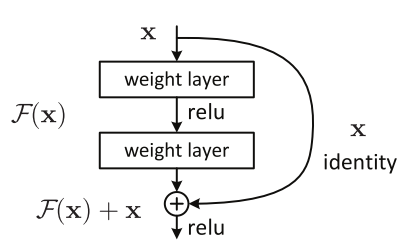

Residual connections can be applied in [different ways](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) and there are parallels to how LSTM networks solve the problem of vanishing gradients (described in the next session).

Below we will see if adding residual connections around the convolutional blocks in our CIFAR-10 image classifier helps with its performance or not. We will use the Keras Functional API to do this.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

### Dataset

In [ ]:
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)

Xtrain /= 256
Xtest /= 256

ytrain = keras.utils.to_categorical(ytrain, num_classes=10)
ytest = keras.utils.to_categorical(ytest, num_classes=10)

### Model

In [ ]:
def conv_pool_block_with_residual(inputs, num_filters, kernel_size, 
                                  pool_size, layer_id):
  # convolution block processing
  conv_out = keras.layers.Conv2D(
      32, kernel_size=kernel_size, activation="relu",
      name="{:s}_conv".format(layer_id))(inputs)
  conv_out = keras.layers.BatchNormalization(
      name="{:s}_bn".format(layer_id))(conv_out)

  # residual block processing: Conv2D is for reshaping
  res_out = keras.layers.Conv2D(
      32, kernel_size=kernel_size,
      name="{:s}_res".format(layer_id))(inputs)
  
  # combine conv_out and res_out
  outputs = keras.layers.Add(
      name="{:s}_add".format(layer_id))([conv_out, res_out])
  outputs = keras.layers.Activation(
      "relu", name="{:s}_relu".format(layer_id))(outputs)
  outputs = keras.layers.MaxPool2D(
      pool_size=pool_size, name="{:s}_pool".format(layer_id))(outputs)

  return outputs


def build_model():
  inputs = keras.layers.Input(shape=(32, 32, 3))

  x = conv_pool_block_with_residual(inputs, 32, (3, 3), (2, 2), "conv_0")
  x = conv_pool_block_with_residual(x, 64, (3, 3), (2, 2), "conv_1")
  x = conv_pool_block_with_residual(x, 128, (3, 3), (2, 2), "conv_2")
  x = keras.layers.Flatten(name="flatten")(x)
  x = keras.layers.Dense(512, activation="relu", name="dense_0")(x)
  x = keras.layers.Dropout(0.4, name="dropout_0")(x)

  outputs = keras.layers.Dense(10, activation="softmax", name="dense_1")(x)

  model = keras.models.Model(inputs=inputs, outputs=outputs)
  return model

model = build_model()

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_0_conv (Conv2D)            (None, 30, 30, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 30, 30, 32)   128         conv_0_conv[0][0]                
__________________________________________________________________________________________________
conv_0_res (Conv2D)             (None, 30, 30, 32)   896         input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
history = model.fit(Xtrain, ytrain, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 1.5757 - accuracy: 0.4305 - val_loss: 1.5304 - val_accuracy: 0.4400
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 1.2138 - accuracy: 0.5637 - val_loss: 1.7157 - val_accuracy: 0.4260
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 1.0835 - accuracy: 0.6169 - val_loss: 1.2765 - val_accuracy: 0.5521
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.9859 - accuracy: 0.6509 - val_loss: 1.1736 - val_accuracy: 0.5833
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.9257 - accuracy: 0.6754 - val_loss: 1.2409 - val_accuracy: 0.5908
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.8794 - accuracy: 0.6910 - val_loss: 1.4060 - val_accuracy: 0.5416
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.8316 - accuracy: 0.7036 - val_loss: 0.9710 - val_accuracy: 0.6606
Epoch 

In [ ]:
score = model.evaluate(Xtest, ytest)
print("test loss: {:.5f}, test accuracy: {:.5f}".format(score[0], score[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.9535 - accuracy: 0.7069
test loss: 0.95355, test accuracy: 0.70690


## Custom Loss Function

Sometimes tasks are defined by external entities, along with success criteria. These success criteria may not be possible to model using existing loss functions, so we would need to create a custom loss function (and metric) that mimics the success criteria.

Other times custom loss functions are driven by data distributions. For example, unbalanced training data (i.e., so some classes are over-represented in the training data), ROC AUC or F1-score may be a better indicator of model performance.

Loss Functions and metrics have the same signature, so a loss function can generally also be used as a metric.

Difference between loss function and metric is that the output of the loss function is used for training the model, whereas the metric is used to judge the performance of the model. Therefore the loss function __must be differentiable__.

Loss function signature:
```
def custom_loss(y_true, y_pred, sample_weights=None)
```

Post Keras 2.3.0, development will continue in `tf.keras` so [only the Tensorflow backend will be supported](https://github.com/keras-team/keras/releases/tag/2.3.0).

So it makes sense to use tf functions directly instead of using the `keras.backend` library.

We will demonstrate how to write a loss function that computes F1 score.

In [ ]:
def f1_score_fn(y_true, y_pred, as_metric=False, num_classes=None):
  if as_metric:
    # for getting true f1 score, pred needs to be 0/1 same as label
    # but that is not differentiable, so for loss to be differentiable
    # it needs to remain as probabilities.
    y_pred = tf.round(y_pred)
  
  tp = tf.reduce_sum(tf.cast(tf.multiply(y_true, y_pred), tf.float32), axis=0)
  tn = tf.reduce_sum(tf.cast(tf.multiply(1 - y_true, 1 - y_pred), tf.float32), axis=0)
  fp = tf.reduce_sum(tf.cast(tf.multiply(1 - y_true, y_pred), tf.float32), axis=0)
  fn = tf.reduce_sum(tf.cast(tf.multiply(y_true, 1 - y_pred), tf.float32), axis=0)

  eps = tf.keras.backend.epsilon()
  precision = tp / (tp + fp + eps)
  recall = tp / (tp + fn + eps) 

  f1 = (2 * precision * recall) / (precision + recall + eps)
  f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

  return tf.reduce_mean(f1)


def f1_loss(y_true, y_pred, sample_weights=None):
  return f1_score_fn(y_true, y_pred)


def f1_metric(y_true, y_pred):
  return f1_score_fn(y_true, y_pred, as_metric=True, num_classes=10)


# Test loss and metric
y_true = ytest[0:32]
y_pred = model.predict(Xtest[0:32])

losses = f1_loss(y_true, y_pred)
metric = f1_metric(y_true, y_pred)

print(y_true.shape, y_pred.shape)
print("losses:", losses)
print("metrics:", metric)

(32, 10) (32, 10)
losses: tf.Tensor(0.6697344, shape=(), dtype=float32)
metrics: tf.Tensor(0.81571424, shape=(), dtype=float32)


In [ ]:
# model_f1 = keras.models.Model(inputs=inputs, outputs=outputs)
model_fl = build_model()

model_fl.compile(optimizer="adam", loss=f1_loss, metrics=["accuracy", f1_metric])
model_fl.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0091 - accuracy: 0.0287 - f1_metric: 0.0085 - val_loss: 0.0101 - val_accuracy: 0.0366 - val_f1_metric: 0.0100
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0086 - accuracy: 0.0290 - f1_metric: 0.0085 - val_loss: 0.0163 - val_accuracy: 0.0801 - val_f1_metric: 0.0163
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0083 - accuracy: 0.0281 - f1_metric: 0.0083 - val_loss: 0.0171 - val_accuracy: 0.0939 - val_f1_metric: 0.0171
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0093 - accuracy: 0.0327 - f1_metric: 0.0093 - val_loss: 0.0084 - val_accuracy: 0.0274 - val_f1_metric: 0.0084
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0095 - accuracy: 0.0356 - f1_metric: 0.0094 - val_loss: 0.0176 - val_accuracy: 0.0974 - val_f1_metric: 0.0176
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - lo

## Learning Rate Schedule

Neural networks learn using the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent), and the update rule for gradient descent is:

$$ W \leftarrow W + \alpha \frac{\partial L}{\partial W} $$

Here $\alpha$ is the learning rate. Generally we just choose a reasonable constant value based on the optimizer.

However, it is recommended to lower the learning rate as training progreeses because of the behavior indicated by this visual.

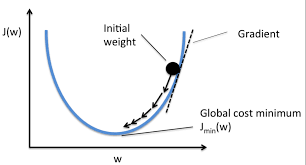


### Built-in Learning Rate Schedules

Keras optimizers allow you to vary the learning rate over the training by allowing `LearningRateSchedule` objects ([see list of built-in schedules](https://keras.io/api/optimizers/learning_rate_schedules/)) to be passed to its `learning_rate` parameter.

In [ ]:
Xtrain.shape, ytrain.shape

((50000, 32, 32, 3), (50000, 10))

In [ ]:
# model_lr = keras.models.Model(inputs=inputs, outputs=outputs)
model_lr = build_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1, decay_steps=100000, decay_rate=0.96, staircase=True)
model_lr.compile(optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
model_lr.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 1.6704 - accuracy: 0.3885 - val_loss: 1.4885 - val_accuracy: 0.4671
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 1.3508 - accuracy: 0.5138 - val_loss: 2.0275 - val_accuracy: 0.3438
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 1.2187 - accuracy: 0.5673 - val_loss: 1.4546 - val_accuracy: 0.4873
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 1.1253 - accuracy: 0.5992 - val_loss: 1.4882 - val_accuracy: 0.5035
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 1.0493 - accuracy: 0.6270 - val_loss: 1.2325 - val_accuracy: 0.5854
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.9957 - accuracy: 0.6494 - val_loss: 1.3406 - val_accuracy: 0.5333
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.9436 - accuracy: 0.6668 - val_loss: 1.2023 - val_accuracy: 0.5806
Epoch 

### LearningRateScheduler callback

If the canned schedulers do not meet your needs, another more flexible approach is to build your own __learning rate schedule__ which you can invoke using the `LearningRateScheduler` callback.

This callback is called at the beginning of every epoch. You have to provide your own `schedule(epoch, learning_rate) -> learning_rate` function in its constructor.

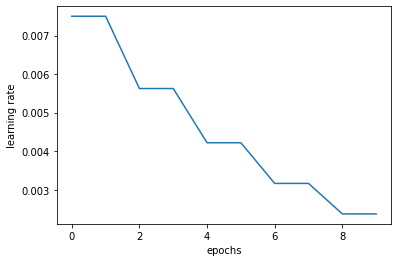

In [ ]:
def schedule_fn(factor=0.25, step_width=2):
  def _schedule(epoch, lr):
    if epoch % step_width == 0:
      return lr - (lr * factor)
    else:
      return lr
  return _schedule

# :self test:
schedule = schedule_fn()

xs, ys = [], []
lr = 0.01
for epoch in range(10):
  lr = schedule(epoch, lr)
  xs.append(epoch)
  ys.append(lr)

plt.plot(xs, ys)
plt.xlabel("epochs")
plt.ylabel("learning rate")
_ = plt.show()

In [ ]:
# model_lr1 = keras.models.Model(inputs=inputs, outputs=outputs)
model_lr1 = build_model()

lrs_callback = keras.callbacks.LearningRateScheduler(schedule)
model_lr1.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model_lr1.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2,
              callbacks=[lrs_callback])

Epoch 1/10
625/625 [==============================] - 3s 6ms/step - loss: 1.8656 - accuracy: 0.3146 - val_loss: 1.7305 - val_accuracy: 0.3633
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 1.5416 - accuracy: 0.4379 - val_loss: 1.7629 - val_accuracy: 0.3890
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 1.4073 - accuracy: 0.4899 - val_loss: 1.3913 - val_accuracy: 0.4909
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 1.3425 - accuracy: 0.5175 - val_loss: 1.5746 - val_accuracy: 0.4535
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 1.2751 - accuracy: 0.5423 - val_loss: 1.2543 - val_accuracy: 0.5506
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 1.2386 - accuracy: 0.5540 - val_loss: 1.2566 - val_accuracy: 0.5556
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 1.1969 - accuracy: 0.5713 - val_loss: 1.2089 - val_accuracy: 0.5669
Epoch 

### Building your own Learning Rate Callback

You can create a custom callback by subclassing `keras.callbacks.Callback` and override the appropriate method(s) that get called at:

* the beginning and end of training, test, and predict,
* beginning and end of batch, and 
* beginning and end of epoch

Leslie Smith describes the idea of tuning networks using Cyclic Learning Rates (CLR) in his papers [A disciplined approach to neural network hyperparameters](https://arxiv.org/abs/1803.09820) and [Cyclic Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

This technique was popularized by Jeremy Howard in his fast.ai lectures and library (which are currently in Pytorch).

Essentially, the idea is to oscillate between a minimum and maximum learning rate during training, rather than a monotonic decay schedule. CLR helps with faster convergence.

The CLR is implemented as a Keras Callback as described earlier. However, someone has already built this and put it in github, and its not exactly trivial, so we will just use their code.

In the next section, we will look at the LR Finder code, which is implemented as a hook into `LambdaCallback`.

In [ ]:
%%bash
(
if [ ! -d "CLR" ]; then
  git clone https://github.com/bckenstler/CLR
fi
)

fatal: destination path 'CLR' already exists and is not an empty directory.


In [ ]:
from CLR.clr_callback import CyclicLR

batch_size = 128
step_size = 4 * Xtrain.shape[0] // batch_size
clr = CyclicLR(mode="triangular2",
               base_lr=1e-7,
               max_lr=1e-2,
               step_size=step_size)

In [ ]:
model_clr = build_model()

model_clr.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
history = model_clr.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2,
                        callbacks=[clr])

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 2.3196 - accuracy: 0.1862 - val_loss: 1.9108 - val_accuracy: 0.3113
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 1.7488 - accuracy: 0.3501 - val_loss: 1.6148 - val_accuracy: 0.4141
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 1.5199 - accuracy: 0.4459 - val_loss: 1.5076 - val_accuracy: 0.4609
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 1.3604 - accuracy: 0.5079 - val_loss: 1.3455 - val_accuracy: 0.5152
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2749 - accuracy: 0.5440 - val_loss: 1.2210 - val_accuracy: 0.5666
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2512 - accuracy: 0.5514 - val_loss: 1.2405 - val_accuracy: 0.5584
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2438 - accuracy: 0.5552 - val_loss: 1.4333 - val_accuracy: 0.5099
Epoch 

In [ ]:
scores = model_clr.evaluate(Xtest, ytest)
print("test loss: {:.5f}, accuracy: {:.5f}".format(scores[0], scores[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.1240 - accuracy: 0.6030
test loss: 1.12398, accuracy: 0.60300


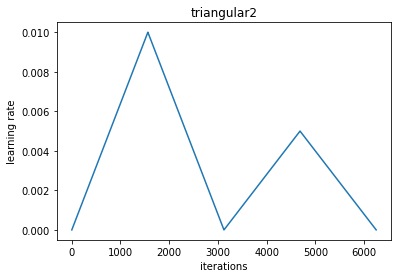

In [ ]:
plt.plot(np.arange(len(clr.history["lr"])), clr.history["lr"])
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.title("triangular2")
_ = plt.show()

### LR Finder as Keras Callback

Learning Rate usage.

* Learning rate range is set to very large interval, typically 1e-5 to 1e+1.
* After each batch, the learning rate is raised exponentially. 
* Model is trained for 3-5 epochs.
* Plot of Loss versus Learning Rate is visually examined and the optimal LR range identified.
* The full model is then trained using CLR using the learning rate ranges found from the LR Finder.

__NOTE__: the [surmenok/keras_lr_finder](https://github.com/surmenok/keras_lr_finder) provides an open source implementation of LR finder, but it is written against the classic Keras, so we will rewrite this using `tf.keras` for our purposes.

In [ ]:
import math
from keras.callbacks import LambdaCallback
import numpy as np

class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        # lr = K.get_value(self.model.optimizer.lr)
        lr = keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        # K.set_value(self.model.optimizer.lr, lr)
        keras.backend.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        # original_lr = K.get_value(self.model.optimizer.lr)
        original_lr = keras.backend.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        # K.set_value(self.model.optimizer.lr, start_lr)
        keras.backend.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        # K.set_value(self.model.optimizer.lr, original_lr)
        keras.backend.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        # original_lr = K.get_value(self.model.optimizer.lr)
        original_lr = keras.backend.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        # K.set_value(self.model.optimizer.lr, start_lr)
        keras.backend.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        # K.set_value(self.model.optimizer.lr, original_lr)
        keras.backend.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
model_lrf = build_model()
model_lrf.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

lr_finder = LRFinder(model_lrf)
lr_finder.find(Xtrain, ytrain, start_lr=1e-7, end_lr=1, batch_size=64, epochs=5)

Epoch 1/5
782/782 [==============================] - 4s 6ms/step - loss: 3.2740 - accuracy: 0.1084
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 3.1219 - accuracy: 0.1080
Epoch 3/5
782/782 [==============================] - 4s 6ms/step - loss: 2.5555 - accuracy: 0.1465
Epoch 4/5
782/782 [==============================] - 4s 6ms/step - loss: 1.8626 - accuracy: 0.3213
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 1.6535 - accuracy: 0.4085


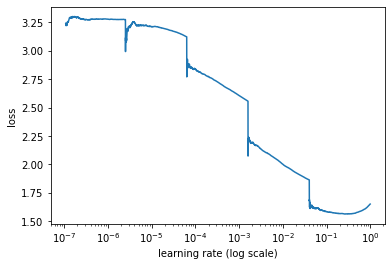

In [ ]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

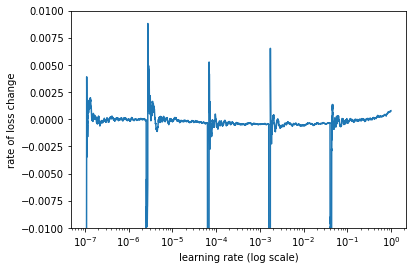

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

We obtain our Learning rate boundaries from the above two plots
* minimum == 1e-4
* maximum == 0.1

We will now train our model with these learning rates for 10 epochs using CLR.

In [ ]:
batch_size = 128
step_size = 4 * Xtrain.shape[0] // batch_size
clr = CyclicLR(mode="triangular2",
               base_lr=1e-4,
               max_lr=1e-1,
               step_size=step_size)

In [ ]:
model_clr = build_model()

clr_callback = keras.callbacks.LearningRateScheduler(schedule)
model_clr.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

history = model_clr.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2,
                        callbacks=[clr])

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 1.9019 - accuracy: 0.3281 - val_loss: 1.8083 - val_accuracy: 0.3633
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 1.4201 - accuracy: 0.4886 - val_loss: 1.4956 - val_accuracy: 0.4623
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 1.2524 - accuracy: 0.5585 - val_loss: 1.5536 - val_accuracy: 0.4910
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 1.0617 - accuracy: 0.6237 - val_loss: 1.0524 - val_accuracy: 0.6377
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.9216 - accuracy: 0.6750 - val_loss: 0.9338 - val_accuracy: 0.6761
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.8656 - accuracy: 0.6962 - val_loss: 0.9592 - val_accuracy: 0.6695
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.8876 - accuracy: 0.6880 - val_loss: 1.1939 - val_accuracy: 0.5892
Epoch 

In [ ]:
scores = model_clr.evaluate(Xtest, ytest)
print("test loss: {:.5f}, accuracy: {:.5f}".format(scores[0], scores[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.8662 - accuracy: 0.7028
test loss: 0.86624, accuracy: 0.70280
